--------------------------------------------------
Starting Vector Addition Tests (Device: cuda)...
--------------------------------------------------
COLD RUN (N=10): CPU Time = 0.000024s
  ✅ WARM AVG (N=10): CPU=0.000005s, GPU=0.000649s, Speedup=0.01x
COLD RUN (N=100): CPU Time = 0.000007s
  ✅ WARM AVG (N=100): CPU=0.000005s, GPU=0.003823s, Speedup=0.00x
COLD RUN (N=1000): CPU Time = 0.000009s
  ✅ WARM AVG (N=1000): CPU=0.000010s, GPU=0.035542s, Speedup=0.00x
COLD RUN (N=50000): CPU Time = 0.000033s
  ✅ WARM AVG (N=50000): CPU=0.000067s, GPU=2.001032s, Speedup=0.00x
COLD RUN (N=10000): CPU Time = 0.000034s
  ✅ WARM AVG (N=10000): CPU=0.000013s, GPU=0.444147s, Speedup=0.00x

--- Generating Line Graphs for Vector Addition Across N Range ---


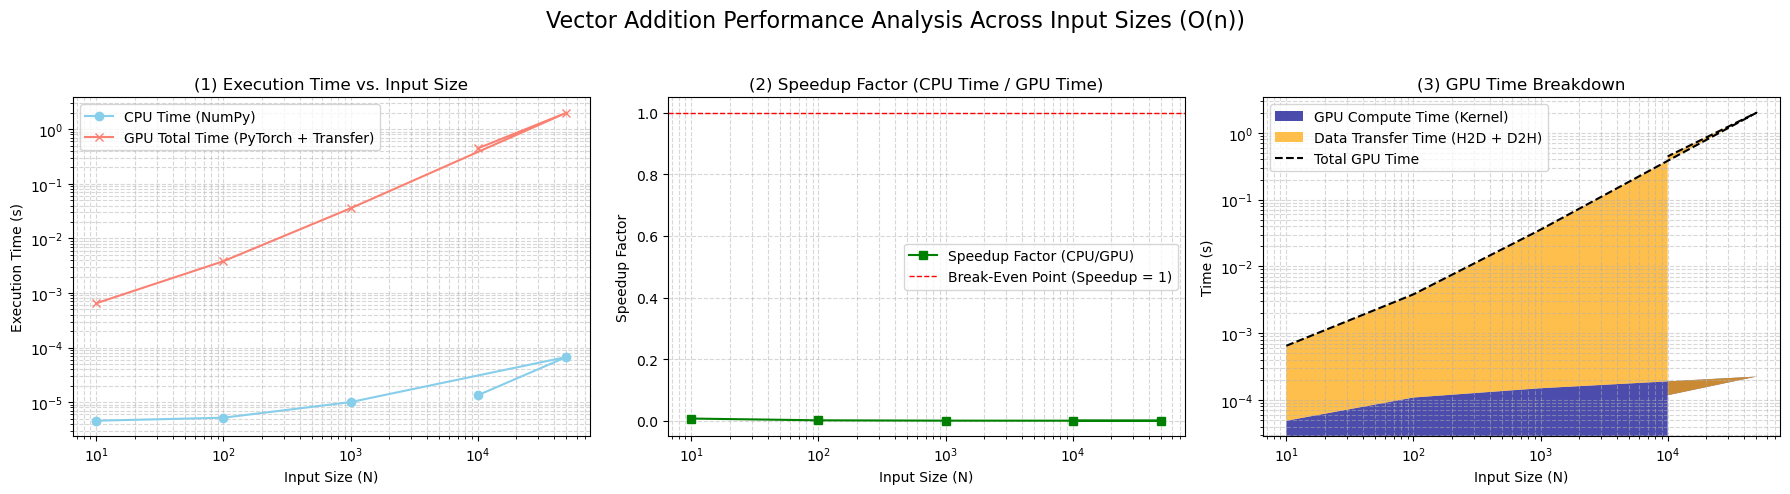

In [1]:
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# --- Configuration ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
TRIES = 5  # Number of warm runs for averaging
INPUT_SIZES = [10**1, 10**2, 10**3, 5*10**4, 10**4] # Range of input sizes (N)
ALGORITHM_NAME = 'Vector Addition'
RESULTS = [] # List to store dicts of results

if DEVICE == 'cpu':
    print("WARNING: CUDA not available. Running all tests on CPU. GPU metrics will be NaN.")

# --- Algorithm Definitions and Setup ---

def setup_vector_add(N):
    a_np, b_np = np.random.rand(N).astype(np.float32), np.random.rand(N).astype(np.float32)
    a_pt, b_pt = torch.from_numpy(a_np), torch.from_numpy(b_np)
    return (a_np, b_np), (a_pt, b_pt)

def vector_add_cpu(a_np, b_np):
    return np.add(a_np, b_np)

def vector_add_gpu(a_pt, b_pt):
    return a_pt + b_pt

# --- Timing and Data Collection Function ---

def run_test_and_collect(N, cpu_func, gpu_func, setup_func, use_transfer_time=True):
    # Setup data
    data_cpu, data_pt = setup_func(N)

    # --- COLD RUN ---
    try:
        # GPU cold run (includes context setup)
        if DEVICE == 'cuda':
            gpu_func(*[d.to(DEVICE) for d in data_pt])
            torch.cuda.synchronize()
        
        # CPU cold run
        start_cpu_cold = time.perf_counter()
        cpu_func(*data_cpu)
        cpu_cold_time = time.perf_counter() - start_cpu_cold
        print(f"COLD RUN (N={N}): CPU Time = {cpu_cold_time:.6f}s")
        
    except Exception as e:
        print(f"Skipping {ALGORITHM_NAME} N={N} due to error: {e}")
        return

    # --- WARM RUNS (Measurement) ---
    cpu_times, gpu_kernel_times, h2d_times, d2h_times = [], [], [], []

    for i in range(TRIES):
        data_cpu, data_pt = setup_func(N)
        
        # 1. CPU Time (Warm)
        start_cpu = time.perf_counter()
        cpu_func(*data_cpu)
        cpu_times.append(time.perf_counter() - start_cpu)

        # 2. GPU Time Breakdown (Warm)
        if DEVICE == 'cuda':
            torch.cuda.synchronize()
            
            # H2D Transfer Time
            start_h2d = time.perf_counter()
            data_pt_cuda = [d.to(DEVICE, non_blocking=True) for d in data_pt]
            torch.cuda.synchronize()
            h2d_time = time.perf_counter() - start_h2d
            
            # Kernel Execution Time
            start_kernel = time.perf_counter()
            gpu_result_cuda = gpu_func(*data_pt_cuda)
            torch.cuda.synchronize()
            kernel_time = time.perf_counter() - start_kernel

            # D2H Transfer Time
            start_d2h = time.perf_counter()
            [r.cpu() for r in gpu_result_cuda if not isinstance(gpu_result_cuda, (list, tuple)) or r is gpu_result_cuda]
            torch.cuda.synchronize()
            d2h_time = time.perf_counter() - start_d2h

            gpu_kernel_times.append(kernel_time)
            h2d_times.append(h2d_time)
            d2h_times.append(d2h_time)

    # --- AGGREGATION ---
    avg_cpu_time = np.mean(cpu_times)
    
    if DEVICE == 'cuda':
        avg_kernel_time = np.mean(gpu_kernel_times)
        avg_transfer_time = np.mean(h2d_times) + np.mean(d2h_times) if use_transfer_time else 0.0
        avg_total_gpu_time = avg_kernel_time + avg_transfer_time
        speedup_factor = avg_cpu_time / avg_total_gpu_time if avg_total_gpu_time > 0 else 0
    else:
        avg_kernel_time = avg_total_gpu_time = avg_transfer_time = np.nan
        speedup_factor = np.nan

    RESULTS.append({
        'N': N, 'CPU_Time_s': avg_cpu_time, 'GPU_Total_Time_s': avg_total_gpu_time,
        'GPU_Kernel_Time_s': avg_kernel_time, 'GPU_Transfer_Time_s': avg_transfer_time,
        'Speedup_Factor': speedup_factor
    })
    print(f"  ✅ WARM AVG (N={N}): CPU={avg_cpu_time:.6f}s, GPU={avg_total_gpu_time:.6f}s, Speedup={speedup_factor:.2f}x")

# --- Execution Loop ---
print("-" * 50)
print(f"Starting {ALGORITHM_NAME} Tests (Device: {DEVICE})...")
print("-" * 50)

for N in INPUT_SIZES:
    run_test_and_collect(N, vector_add_cpu, vector_add_gpu, setup_vector_add)

# --- Prepare Data for Plotting ---
N_range = np.array([r['N'] for r in RESULTS])
cpu_avg_times_data = np.array([r['CPU_Time_s'] for r in RESULTS])
gpu_total_times_data = np.array([r['GPU_Total_Time_s'] for r in RESULTS])
gpu_kernel_times_data = np.array([r['GPU_Kernel_Time_s'] for r in RESULTS])
gpu_transfer_times_data = np.array([r['GPU_Transfer_Time_s'] for r in RESULTS])
speedup_factors_data = np.array([r['Speedup_Factor'] for r in RESULTS])


# --- 2. GENERATE LINE GRAPHS (Section 5) ---

print("\n--- Generating Line Graphs for Vector Addition Across N Range ---")

# Setup figure for 3 plots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Vector Addition Performance Analysis Across Input Sizes (O(n))', fontsize=16)


# --- Plot 1: Execution Time vs Input Size (Log-Log Plot) ---
axs[0].plot(N_range, cpu_avg_times_data, marker='o', label='CPU Time (NumPy)', color='skyblue')
axs[0].plot(N_range, gpu_total_times_data, marker='x', label='GPU Total Time (PyTorch + Transfer)', color='salmon')

axs[0].set_title('(1) Execution Time vs. Input Size')
axs[0].set_xlabel('Input Size (N)', fontsize=10)
axs[0].set_ylabel('Execution Time (s)', fontsize=10)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].grid(True, which="both", ls="--", alpha=0.5)
axs[0].legend()


# --- Plot 2: Speedup Factor (Log-X Plot) ---
axs[1].plot(N_range, speedup_factors_data, marker='s', label='Speedup Factor (CPU/GPU)', color='green')
axs[1].axhline(1.0, color='r', linestyle='--', linewidth=1, label='Break-Even Point (Speedup = 1)')

axs[1].set_title('(2) Speedup Factor (CPU Time / GPU Time)')
axs[1].set_xlabel('Input Size (N)', fontsize=10)
axs[1].set_ylabel('Speedup Factor', fontsize=10)
axs[1].set_xscale('log')
axs[1].grid(True, which="both", ls="--", alpha=0.5)
axs[1].legend()


# --- Plot 3: Time Breakdown (GPU Compute + Transfer Times) (Stacked Area Plot) ---
# A stacked area chart best shows the relative contribution over N.

axs[2].stackplot(N_range, 
                 gpu_kernel_times_data, 
                 gpu_transfer_times_data, 
                 labels=['GPU Compute Time (Kernel)', 'Data Transfer Time (H2D + D2H)'], 
                 colors=['darkblue', 'orange'],
                 alpha=0.7)
axs[2].plot(N_range, gpu_total_times_data, color='black', linestyle='--', label='Total GPU Time')

axs[2].set_title('(3) GPU Time Breakdown')
axs[2].set_xlabel('Input Size (N)', fontsize=10)
axs[2].set_ylabel('Time (s)', fontsize=10)
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].grid(True, which="both", ls="--", alpha=0.5)
axs[2].legend(loc='upper left')


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

--------------------------------------------------
Starting Matrix Multiplication Tests (Device: cuda)...
--------------------------------------------------
COLD RUN (N=128): CPU Time = 0.000273s, GPU Total Time = 0.072615s
  ✅ WARM AVG (N=128): CPU=0.000323s, GPU=0.006639s, Speedup=0.05x
     -> BREAKDOWN: Kernel=0.000146s, Transfer (H2D)=0.000663s, Transfer (D2H)=0.005831s
COLD RUN (N=256): CPU Time = 0.000544s, GPU Total Time = 0.137597s
  ✅ WARM AVG (N=256): CPU=0.000606s, GPU=0.014085s, Speedup=0.04x
     -> BREAKDOWN: Kernel=0.002130s, Transfer (H2D)=0.000630s, Transfer (D2H)=0.011325s
COLD RUN (N=512): CPU Time = 0.001497s, GPU Total Time = 0.306390s
  ✅ WARM AVG (N=512): CPU=0.001435s, GPU=0.017995s, Speedup=0.08x
     -> BREAKDOWN: Kernel=0.000427s, Transfer (H2D)=0.000758s, Transfer (D2H)=0.016810s
COLD RUN (N=1024): CPU Time = 0.009430s, GPU Total Time = 0.711448s
  ✅ WARM AVG (N=1024): CPU=0.006541s, GPU=0.035910s, Speedup=0.18x
     -> BREAKDOWN: Kernel=0.000630s, Transfer

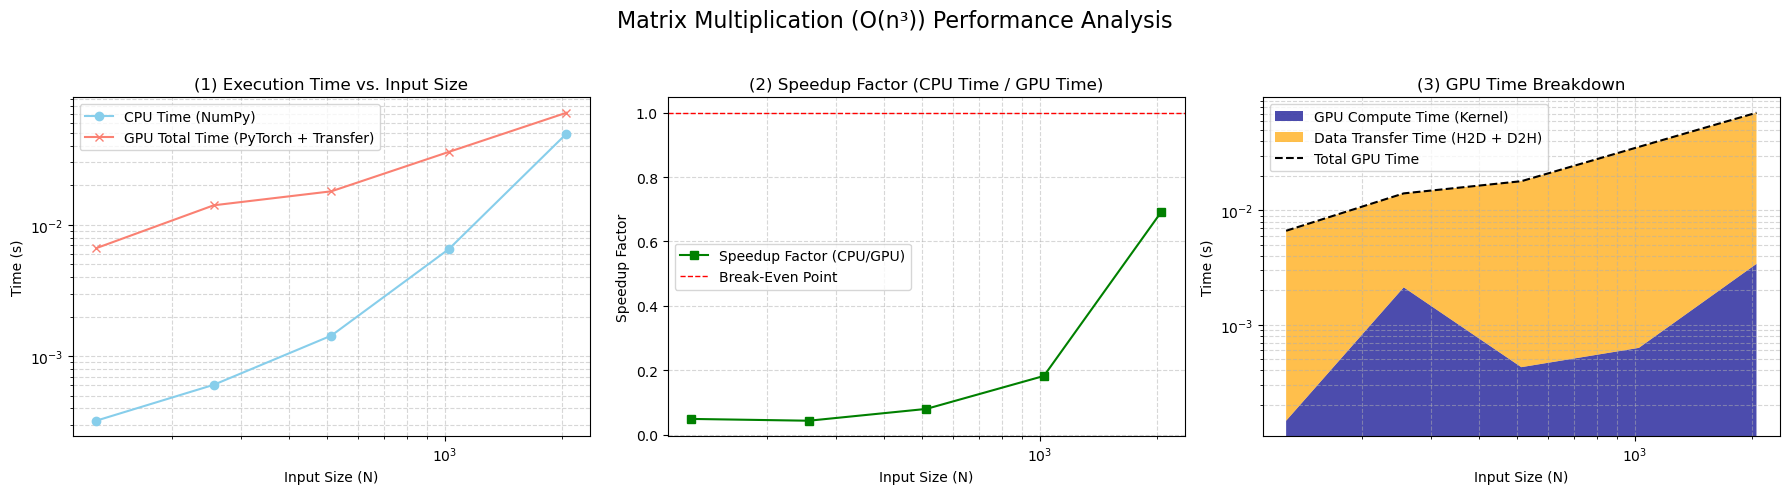

In [ ]:
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# --- Configuration ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
TRIES = 5
INPUT_SIZES = [128, 256, 512, 1024, 2048] 
ALGORITHM_NAME = 'Matrix Multiplication'
RESULTS = [] 

# --- Algorithm Definitions and Setup ---
def setup_mat_mul(N):
    a_np, b_np = np.random.rand(N, N).astype(np.float32), np.random.rand(N, N).astype(np.float32)
    a_pt, b_pt = torch.from_numpy(a_np), torch.from_numpy(b_np)
    return (a_np, b_np), (a_pt, b_pt)

def mat_mul_cpu(a_np, b_np):
    return a_np @ b_np

def mat_mul_gpu(a_pt, b_pt):
    return torch.matmul(a_pt, b_pt)

# --- Timing and Data Collection Function (Modified to print all metrics) ---
def run_test_and_collect(N, cpu_func, gpu_func, setup_func, use_transfer_time=True):
    
    # 1. COLD RUN MEASUREMENT (Printed)
    try:
        data_cpu, data_pt = setup_func(N)
        
        # CPU Cold Run
        start_cpu_cold = time.perf_counter()
        cpu_func(*data_cpu)
        cpu_cold_time = time.perf_counter() - start_cpu_cold

        # GPU Cold Run (with full transfer/kernel cycle)
        if DEVICE == 'cuda':
            torch.cuda.synchronize()
            start_gpu_cold = time.perf_counter()
            data_pt_cuda = [d.to(DEVICE) for d in data_pt]
            gpu_func(*data_pt_cuda)
            [r.cpu() for r in gpu_func(*data_pt_cuda) if not isinstance(gpu_func(*data_pt_cuda), (list, tuple)) or r is gpu_func(*data_pt_cuda)]
            torch.cuda.synchronize()
            gpu_cold_time = time.perf_counter() - start_gpu_cold
        else:
            gpu_cold_time = float('nan')

        print(f"COLD RUN (N={N}): CPU Time = {cpu_cold_time:.6f}s, GPU Total Time = {gpu_cold_time:.6f}s")
        
    except Exception as e:
        print(f"Skipping {ALGORITHM_NAME} N={N} due to error (OOM/other): {e}")
        return

    # 2. WARM RUNS MEASUREMENT
    cpu_times, gpu_kernel_times, h2d_times, d2h_times = [], [], [], []

    for i in range(TRIES):
        data_cpu, data_pt = setup_func(N)
        # CPU Time
        start_cpu = time.perf_counter()
        cpu_func(*data_cpu)
        cpu_times.append(time.perf_counter() - start_cpu)

        # GPU Time Breakdown
        if DEVICE == 'cuda':
            torch.cuda.synchronize()
            start_h2d = time.perf_counter()
            data_pt_cuda = [d.to(DEVICE, non_blocking=True) for d in data_pt]
            torch.cuda.synchronize()
            h2d_time = time.perf_counter() - start_h2d
            
            start_kernel = time.perf_counter()
            gpu_result_cuda = gpu_func(*data_pt_cuda)
            torch.cuda.synchronize()
            kernel_time = time.perf_counter() - start_kernel

            start_d2h = time.perf_counter()
            [r.cpu() for r in gpu_result_cuda if not isinstance(gpu_result_cuda, (list, tuple)) or r is gpu_result_cuda]
            torch.cuda.synchronize()
            d2h_time = time.perf_counter() - start_d2h

            gpu_kernel_times.append(kernel_time)
            h2d_times.append(h2d_time)
            d2h_times.append(d2h_time)

    # 3. AGGREGATION & PRINTING (Printed)
    avg_cpu_time = np.mean(cpu_times)
    
    if DEVICE == 'cuda':
        avg_kernel_time = np.mean(gpu_kernel_times)
        avg_h2d_time = np.mean(h2d_times)
        avg_d2h_time = np.mean(d2h_times)
        avg_transfer_time = avg_h2d_time + avg_d2h_time if use_transfer_time else 0.0
        avg_total_gpu_time = avg_kernel_time + avg_transfer_time
        speedup_factor = avg_cpu_time / avg_total_gpu_time if avg_total_gpu_time > 0 else 0
    else:
        avg_kernel_time = avg_total_gpu_time = avg_transfer_time = np.nan
        speedup_factor = np.nan
        avg_h2d_time = avg_d2h_time = np.nan # Define for printing

    RESULTS.append({
        'N': N, 'CPU_Time_s': avg_cpu_time, 'GPU_Total_Time_s': avg_total_gpu_time,
        'GPU_Kernel_Time_s': avg_kernel_time, 'GPU_Transfer_Time_s': avg_transfer_time,
        'Speedup_Factor': speedup_factor
    })
    
    # NEW PRINT STATEMENT: WARM AVERAGE WITH TRANSFER DETAILS
    print(f"  ✅ WARM AVG (N={N}): CPU={avg_cpu_time:.6f}s, GPU={avg_total_gpu_time:.6f}s, Speedup={speedup_factor:.2f}x")
    if DEVICE == 'cuda':
        print(f"     -> BREAKDOWN: Kernel={avg_kernel_time:.6f}s, Transfer (H2D)={avg_h2d_time:.6f}s, Transfer (D2H)={avg_d2h_time:.6f}s")


# --- Execution Loop ---
print("-" * 50)
print(f"Starting {ALGORITHM_NAME} Tests (Device: {DEVICE})...")
print("-" * 50)

for N in INPUT_SIZES:
    run_test_and_collect(N, mat_mul_cpu, mat_mul_gpu, setup_mat_mul)

# Convert results list to NumPy arrays for easy plotting
N_range = np.array([r['N'] for r in RESULTS])
cpu_times = np.array([r['CPU_Time_s'] for r in RESULTS])
gpu_total_times = np.array([r['GPU_Total_Time_s'] for r in RESULTS])
gpu_kernel_times = np.array([r['GPU_Kernel_Time_s'] for r in RESULTS])
gpu_transfer_times = np.array([r['GPU_Transfer_Time_s'] for r in RESULTS])
speedup_factors = np.array([r['Speedup_Factor'] for r in RESULTS])


# --- Plotting Function (No change needed here, as the input data is now robust) ---
def plot_results(title):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'{title} Performance Analysis', fontsize=16)

    # Plot 1: Execution Time vs Input Size (Log-Log Plot)
    axs[0].plot(N_range, cpu_times, marker='o', label='CPU Time (NumPy)', color='skyblue')
    axs[0].plot(N_range, gpu_total_times, marker='x', label='GPU Total Time (PyTorch + Transfer)', color='salmon')
    axs[0].set_title('(1) Execution Time vs. Input Size'); axs[0].set_xlabel('Input Size (N)'); axs[0].set_ylabel('Time (s)')
    axs[0].set_xscale('log'); axs[0].set_yscale('log'); axs[0].grid(True, which="both", ls="--", alpha=0.5); axs[0].legend()

    # Plot 2: Speedup Factor (Log-X Plot)
    axs[1].plot(N_range, speedup_factors, marker='s', label='Speedup Factor (CPU/GPU)', color='green')
    axs[1].axhline(1.0, color='r', linestyle='--', linewidth=1, label='Break-Even Point'); axs[1].set_title('(2) Speedup Factor (CPU Time / GPU Time)')
    axs[1].set_xlabel('Input Size (N)'); axs[1].set_ylabel('Speedup Factor'); axs[1].set_xscale('log'); axs[1].grid(True, which="both", ls="--", alpha=0.5); axs[1].legend()

    # Plot 3: Time Breakdown (Stacked Area Plot)
    axs[2].stackplot(N_range, gpu_kernel_times, gpu_transfer_times, 
                     labels=['GPU Compute Time (Kernel)', 'Data Transfer Time (H2D + D2H)'], colors=['darkblue', 'orange'], alpha=0.7)
    axs[2].plot(N_range, gpu_total_times, color='black', linestyle='--', label='Total GPU Time')
    axs[2].set_title('(3) GPU Time Breakdown'); axs[2].set_xlabel('Input Size (N)'); axs[2].set_ylabel('Time (s)'); axs[2].set_xscale('log')
    if (gpu_total_times > 0).any(): axs[2].set_yscale('log')
    axs[2].grid(True, which="both", ls="--", alpha=0.5); axs[2].legend(loc='upper left')

    plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

# --- Plot Generation ---
print("\n" + "=" * 50)
print(f"PLOTTING {ALGORITHM_NAME} RESULTS")
print("=" * 50)

plot_results(f'{ALGORITHM_NAME} (O(n³))')

--------------------------------------------------
Starting Merge Sort Tests (Device: cuda)...
--------------------------------------------------
COLD RUN (N=10): CPU Time = 0.000005s, GPU Total Time = 0.006408s
  ✅ WARM AVG (N=10): CPU=0.000008s, GPU=0.001376s, Speedup=0.01x
     -> BREAKDOWN: Kernel=0.000319s, Transfer (H2D)=0.000512s, Transfer (D2H)=0.000546s
COLD RUN (N=20): CPU Time = 0.000005s, GPU Total Time = 0.004628s
  ✅ WARM AVG (N=20): CPU=0.000006s, GPU=0.001345s, Speedup=0.00x
     -> BREAKDOWN: Kernel=0.000150s, Transfer (H2D)=0.000419s, Transfer (D2H)=0.000776s
COLD RUN (N=30): CPU Time = 0.000005s, GPU Total Time = 0.010882s
  ✅ WARM AVG (N=30): CPU=0.000007s, GPU=0.002687s, Speedup=0.00x
     -> BREAKDOWN: Kernel=0.000197s, Transfer (H2D)=0.001035s, Transfer (D2H)=0.001455s
COLD RUN (N=40): CPU Time = 0.000005s, GPU Total Time = 0.020402s
  ✅ WARM AVG (N=40): CPU=0.000011s, GPU=0.002988s, Speedup=0.00x
     -> BREAKDOWN: Kernel=0.000444s, Transfer (H2D)=0.000691s, Tra

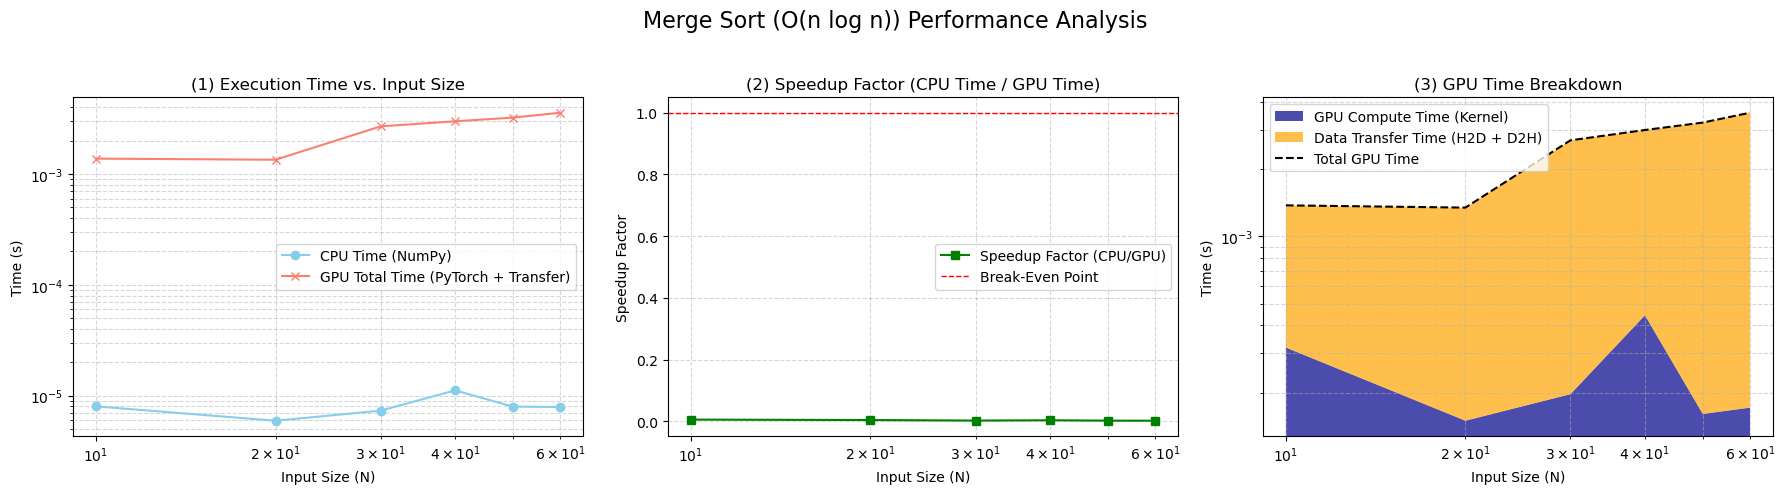

In [16]:
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# --- Configuration ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
TRIES = 5 # Number of warm runs for averaging
# Array length N (up to 10 million elements)
INPUT_SIZES = [10, 20,30, 40, 50,60] 
ALGORITHM_NAME = 'Merge Sort'
RESULTS = [] # List to store dictionaries of results

# --- Algorithm Definitions and Setup ---

def setup_merge_sort(N):
    """Generates random data array for sorting."""
    # Use standard integers for stability in sorting
    a_np = np.random.randint(0, N, N, dtype=np.int32)
    a_pt = torch.from_numpy(a_np)
    # Return copies/clones so original data state is preserved for each run
    return (a_np.copy(),), (a_pt.clone(),) 

def merge_sort_cpu(a_np):
    """CPU Merge Sort (using NumPy's highly optimized np.sort)."""
    return np.sort(a_np)

def merge_sort_gpu(a_pt):
    """GPU Merge Sort (using PyTorch's optimized torch.sort)."""
    # torch.sort returns (values, indices), we take values [cite: 6]
    return torch.sort(a_pt)[0]

# --- Timing and Data Collection Function (Includes Cold/Warm/Transfer) ---
def run_test_and_collect(N, cpu_func, gpu_func, setup_func, use_transfer_time=True):
    
    # --- Validation (Ensure correctness before timing) ---
    data_cpu_val, data_pt_val = setup_func(N=100) # Use a small N for validation
    cpu_result = cpu_func(*data_cpu_val)
    gpu_result_pt = gpu_func(*data_pt_val).cpu()
    assert np.all(np.diff(cpu_result) >= 0), "Validation Failed: CPU result is not sorted."
    assert np.allclose(cpu_result, gpu_result_pt.numpy(), atol=1e-5), "Validation Failed: CPU and GPU results do not match."

    # 1. COLD RUN MEASUREMENT (Printed)
    try:
        data_cpu, data_pt = setup_func(N)
        
        # CPU Cold Run
        start_cpu_cold = time.perf_counter()
        cpu_func(*data_cpu)
        cpu_cold_time = time.perf_counter() - start_cpu_cold

        # GPU Cold Run (full cycle: H2D + Kernel + D2H)
        if DEVICE == 'cuda':
            torch.cuda.synchronize()
            start_gpu_cold = time.perf_counter()
            data_pt_cuda = [d.to(DEVICE) for d in data_pt]
            gpu_func(*data_pt_cuda)
            [r.cpu() for r in gpu_func(*data_pt_cuda) if not isinstance(gpu_func(*data_pt_cuda), (list, tuple)) or r is gpu_func(*data_pt_cuda)]
            torch.cuda.synchronize()
            gpu_cold_time = time.perf_counter() - start_gpu_cold
        else:
            gpu_cold_time = float('nan')

        print(f"COLD RUN (N={N}): CPU Time = {cpu_cold_time:.6f}s, GPU Total Time = {gpu_cold_time:.6f}s")
        
    except Exception as e:
        print(f"Skipping {ALGORITHM_NAME} N={N} due to error (OOM/other): {e}")
        return

    # 2. WARM RUNS MEASUREMENT
    cpu_times, gpu_kernel_times, h2d_times, d2h_times = [], [], [], []

    for i in range(TRIES):
        data_cpu, data_pt = setup_func(N)
        # CPU Time
        start_cpu = time.perf_counter()
        cpu_func(*data_cpu)
        cpu_times.append(time.perf_counter() - start_cpu)

        # GPU Time Breakdown
        if DEVICE == 'cuda':
            torch.cuda.synchronize()
            start_h2d = time.perf_counter()
            data_pt_cuda = [d.to(DEVICE, non_blocking=True) for d in data_pt]
            torch.cuda.synchronize()
            h2d_time = time.perf_counter() - start_h2d
            
            start_kernel = time.perf_counter()
            gpu_result_cuda = gpu_func(*data_pt_cuda)
            torch.cuda.synchronize()
            kernel_time = time.perf_counter() - start_kernel

            start_d2h = time.perf_counter()
            [r.cpu() for r in gpu_result_cuda if not isinstance(gpu_result_cuda, (list, tuple)) or r is gpu_result_cuda]
            torch.cuda.synchronize()
            d2h_time = time.perf_counter() - start_d2h

            gpu_kernel_times.append(kernel_time)
            h2d_times.append(h2d_time)
            d2h_times.append(d2h_time)

    # 3. AGGREGATION & PRINTING (Printed)
    avg_cpu_time = np.mean(cpu_times)
    
    if DEVICE == 'cuda':
        avg_kernel_time = np.mean(gpu_kernel_times)
        avg_h2d_time = np.mean(h2d_times)
        avg_d2h_time = np.mean(d2h_times)
        avg_transfer_time = avg_h2d_time + avg_d2h_time if use_transfer_time else 0.0
        avg_total_gpu_time = avg_kernel_time + avg_transfer_time
        speedup_factor = avg_cpu_time / avg_total_gpu_time if avg_total_gpu_time > 0 else 0
    else:
        avg_kernel_time = avg_total_gpu_time = avg_transfer_time = np.nan
        speedup_factor = np.nan
        avg_h2d_time = avg_d2h_time = np.nan

    RESULTS.append({
        'N': N, 'CPU_Time_s': avg_cpu_time, 'GPU_Total_Time_s': avg_total_gpu_time,
        'GPU_Kernel_Time_s': avg_kernel_time, 'GPU_Transfer_Time_s': avg_transfer_time,
        'Speedup_Factor': speedup_factor
    })
    
    # WARM AVERAGE WITH TRANSFER DETAILS
    print(f"  ✅ WARM AVG (N={N}): CPU={avg_cpu_time:.6f}s, GPU={avg_total_gpu_time:.6f}s, Speedup={speedup_factor:.2f}x")
    if DEVICE == 'cuda':
        print(f"     -> BREAKDOWN: Kernel={avg_kernel_time:.6f}s, Transfer (H2D)={avg_h2d_time:.6f}s, Transfer (D2H)={avg_d2h_time:.6f}s")


# --- Execution Loop ---
print("-" * 50)
print(f"Starting {ALGORITHM_NAME} Tests (Device: {DEVICE})...")
print("-" * 50)

for N in INPUT_SIZES:
    run_test_and_collect(N, merge_sort_cpu, merge_sort_gpu, setup_merge_sort)

# Convert results list to NumPy arrays for easy plotting
N_range = np.array([r['N'] for r in RESULTS])
cpu_times = np.array([r['CPU_Time_s'] for r in RESULTS])
gpu_total_times = np.array([r['GPU_Total_Time_s'] for r in RESULTS])
gpu_kernel_times = np.array([r['GPU_Kernel_Time_s'] for r in RESULTS])
gpu_transfer_times = np.array([r['GPU_Transfer_Time_s'] for r in RESULTS])
speedup_factors = np.array([r['Speedup_Factor'] for r in RESULTS])


# --- Plotting Function ---
def plot_results(title):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'{title} Performance Analysis', fontsize=16)

    # Plot 1: Execution Time vs Input Size (Log-Log Plot) [cite: 13]
    axs[0].plot(N_range, cpu_times, marker='o', label='CPU Time (NumPy)', color='skyblue')
    axs[0].plot(N_range, gpu_total_times, marker='x', label='GPU Total Time (PyTorch + Transfer)', color='salmon')
    axs[0].set_title('(1) Execution Time vs. Input Size'); axs[0].set_xlabel('Input Size (N)'); axs[0].set_ylabel('Time (s)')
    axs[0].set_xscale('log'); axs[0].set_yscale('log'); axs[0].grid(True, which="both", ls="--", alpha=0.5); axs[0].legend()

    # Plot 2: Speedup Factor (Log-X Plot) [cite: 13]
    axs[1].plot(N_range, speedup_factors, marker='s', label='Speedup Factor (CPU/GPU)', color='green')
    axs[1].axhline(1.0, color='r', linestyle='--', linewidth=1, label='Break-Even Point'); axs[1].set_title('(2) Speedup Factor (CPU Time / GPU Time)')
    axs[1].set_xlabel('Input Size (N)'); axs[1].set_ylabel('Speedup Factor'); axs[1].set_xscale('log'); axs[1].grid(True, which="both", ls="--", alpha=0.5); axs[1].legend()

    # Plot 3: Time Breakdown (Stacked Area Plot) [cite: 13]
    axs[2].stackplot(N_range, gpu_kernel_times, gpu_transfer_times, 
                     labels=['GPU Compute Time (Kernel)', 'Data Transfer Time (H2D + D2H)'], colors=['darkblue', 'orange'], alpha=0.7)
    axs[2].plot(N_range, gpu_total_times, color='black', linestyle='--', label='Total GPU Time')
    axs[2].set_title('(3) GPU Time Breakdown'); axs[2].set_xlabel('Input Size (N)'); axs[2].set_ylabel('Time (s)'); axs[2].set_xscale('log')
    if (gpu_total_times > 0).any(): axs[2].set_yscale('log')
    axs[2].grid(True, which="both", ls="--", alpha=0.5); axs[2].legend(loc='upper left')

    plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

# --- Plot Generation ---
print("\n" + "=" * 50)
print(f"PLOTTING {ALGORITHM_NAME} RESULTS")
print("=" * 50)

plot_results(f'{ALGORITHM_NAME} (O(n log n))')

--------------------------------------------------
Starting Fibonacci (Closed-Form) Tests (Device: cuda)...
--------------------------------------------------
COLD RUN (N=5): CPU Time = 0.000065s, GPU Total Time = 0.078147s
  ✅ WARM AVG (N=5): CPU=0.000032s, GPU=0.000331s, Speedup=0.10x
     -> BREAKDOWN: Kernel=0.000331s, Transfer (Total)=0.000000s
COLD RUN (N=6): CPU Time = 0.000019s, GPU Total Time = 0.000372s
  ✅ WARM AVG (N=6): CPU=0.000021s, GPU=0.000305s, Speedup=0.07x
     -> BREAKDOWN: Kernel=0.000305s, Transfer (Total)=0.000000s
COLD RUN (N=7): CPU Time = 0.000017s, GPU Total Time = 0.000313s
  ✅ WARM AVG (N=7): CPU=0.000020s, GPU=0.000345s, Speedup=0.06x
     -> BREAKDOWN: Kernel=0.000345s, Transfer (Total)=0.000000s
COLD RUN (N=8): CPU Time = 0.000018s, GPU Total Time = 0.000344s
  ✅ WARM AVG (N=8): CPU=0.000019s, GPU=0.000345s, Speedup=0.06x
     -> BREAKDOWN: Kernel=0.000345s, Transfer (Total)=0.000000s
COLD RUN (N=9): CPU Time = 0.000016s, GPU Total Time = 0.000296s
  ✅ 

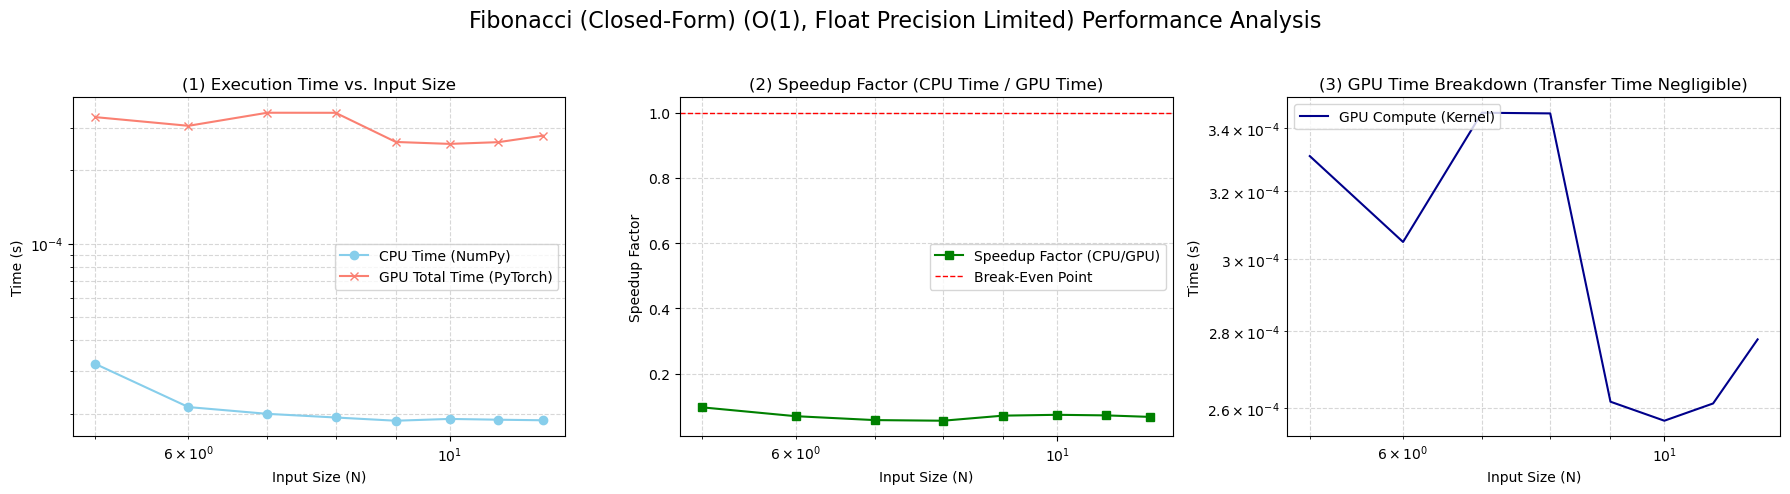

In [1]:
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# --- Configuration ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
TRIES = 5 # Number of warm runs for averaging
# WARNING: Input sizes must be kept low (N < 75) for accurate results due to float precision limits.
INPUT_SIZES = [5, 6, 7, 8, 9, 10, 11, 12] 
ALGORITHM_NAME = 'Fibonacci (Closed-Form)'
RESULTS = []

# --- Constants (Defined as 64-bit floats for precision) ---
SQRT_5 = np.sqrt(5.0, dtype=np.float64)
PHI = (1.0 + SQRT_5) / 2.0
ONE_MINUS_PHI = 1.0 - PHI

# --- Algorithm Definitions and Setup ---

def setup_fibonacci(N):
    # N is the exponent, which remains the argument for the function call.
    return (N,), (N,) 

def fibonacci_cpu(N):
    """CPU Fibonacci using the Closed-Form Expression (NumPy). O(1)"""
    if N <= 1: return N
    # Calculate F_N using floating point power
    num = np.power(PHI, N) - np.power(ONE_MINUS_PHI, N)
    # Round to the nearest integer
    return np.round(num / SQRT_5).astype(np.int64)

def fibonacci_gpu(N):
    """GPU Fibonacci using the Closed-Form Expression (PyTorch CUDA). O(1)"""
    if N <= 1: return N
    
    # Convert scalar constants to CUDA tensors within the function scope
    # (Transfer time is still negligible/zero due to the constants being scalars)
    phi_pt = torch.tensor(PHI, dtype=torch.float64, device=DEVICE)
    one_minus_phi_pt = torch.tensor(ONE_MINUS_PHI, dtype=torch.float64, device=DEVICE)
    sqrt_5_pt = torch.tensor(SQRT_5, dtype=torch.float64, device=DEVICE)
    
    # The torch.pow operation replaces the loop/matrix multiplication
    num = torch.pow(phi_pt, N) - torch.pow(one_minus_phi_pt, N)
    
    # Calculate, round, and return as a scalar integer
    return torch.round(num / sqrt_5_pt).item()


# --- Timing and Data Collection Function (Includes Cold/Warm/Transfer) ---
def run_test_and_collect(N, cpu_func, gpu_func, setup_func, use_transfer_time=False):
    
    # 1. COLD RUN MEASUREMENT (Printed)
    try:
        data_cpu, data_pt = setup_func(N)
        
        # CPU Cold Run
        start_cpu_cold = time.perf_counter()
        cpu_func(*data_cpu)
        cpu_cold_time = time.perf_counter() - start_cpu_cold

        # GPU Cold Run (with full transfer/kernel cycle)
        if DEVICE == 'cuda':
            torch.cuda.synchronize()
            start_gpu_cold = time.perf_counter()
            gpu_func(*data_pt)
            torch.cuda.synchronize()
            gpu_cold_time = time.perf_counter() - start_gpu_cold
        else:
            gpu_cold_time = float('nan')

        print(f"COLD RUN (N={N}): CPU Time = {cpu_cold_time:.6f}s, GPU Total Time = {gpu_cold_time:.6f}s")
        
    except Exception as e:
        print(f"Skipping {ALGORITHM_NAME} N={N} due to error: {e}")
        return

    # 2. WARM RUNS MEASUREMENT
    cpu_times, gpu_kernel_times = [], []

    for i in range(TRIES):
        data_cpu, data_pt = setup_func(N)
        # CPU Time
        start_cpu = time.perf_counter()
        cpu_func(*data_cpu)
        cpu_times.append(time.perf_counter() - start_cpu)

        # GPU Time Breakdown (Kernel only)
        if DEVICE == 'cuda':
            torch.cuda.synchronize()
            start_kernel = time.perf_counter()
            gpu_func(*data_pt)
            torch.cuda.synchronize()
            kernel_time = time.perf_counter() - start_kernel
            gpu_kernel_times.append(kernel_time)

    # 3. AGGREGATION & PRINTING (Printed)
    avg_cpu_time = np.mean(cpu_times)
    
    if DEVICE == 'cuda':
        avg_kernel_time = np.mean(gpu_kernel_times)
        avg_transfer_time = 0.0 # Negligible for O(1) scalar operation
        avg_total_gpu_time = avg_kernel_time
        speedup_factor = avg_cpu_time / avg_total_gpu_time if avg_total_gpu_time > 0 else 0
    else:
        avg_kernel_time = avg_total_gpu_time = avg_transfer_time = np.nan
        speedup_factor = np.nan

    RESULTS.append({
        'N': N, 'CPU_Time_s': avg_cpu_time, 'GPU_Total_Time_s': avg_total_gpu_time,
        'GPU_Kernel_Time_s': avg_kernel_time, 'GPU_Transfer_Time_s': avg_transfer_time,
        'Speedup_Factor': speedup_factor
    })
    
    # WARM AVERAGE WITH KERNEL DETAILS
    print(f"  ✅ WARM AVG (N={N}): CPU={avg_cpu_time:.6f}s, GPU={avg_total_gpu_time:.6f}s, Speedup={speedup_factor:.2f}x")
    if DEVICE == 'cuda':
        # Transfer time is 0.000000s and D2H/H2D are not separately timed, so we only show Kernel time.
        print(f"     -> BREAKDOWN: Kernel={avg_kernel_time:.6f}s, Transfer (Total)=0.000000s")


# --- Execution Loop ---
print("-" * 50)
print(f"Starting {ALGORITHM_NAME} Tests (Device: {DEVICE})...")
print("-" * 50)

for N in INPUT_SIZES:
    run_test_and_collect(N, fibonacci_cpu, fibonacci_gpu, setup_fibonacci, use_transfer_time=False)

# Convert results list to NumPy arrays for easy plotting
N_range = np.array([r['N'] for r in RESULTS])
cpu_times = np.array([r['CPU_Time_s'] for r in RESULTS])
gpu_total_times = np.array([r['GPU_Total_Time_s'] for r in RESULTS])
gpu_kernel_times = np.array([r['GPU_Kernel_Time_s'] for r in RESULTS])
speedup_factors = np.array([r['Speedup_Factor'] for r in RESULTS])

# --- Plotting Function ---
def plot_results(title):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'{title} Performance Analysis', fontsize=16)

    # Plot 1: Execution Time vs Input Size (Log-Log Plot)
    axs[0].plot(N_range, cpu_times, marker='o', label='CPU Time (NumPy)', color='skyblue')
    axs[0].plot(N_range, gpu_total_times, marker='x', label='GPU Total Time (PyTorch)', color='salmon')
    axs[0].set_title('(1) Execution Time vs. Input Size'); axs[0].set_xlabel('Input Size (N)'); axs[0].set_ylabel('Time (s)')
    axs[0].set_xscale('log'); axs[0].set_yscale('log'); axs[0].grid(True, which="both", ls="--", alpha=0.5); axs[0].legend()

    # Plot 2: Speedup Factor (Log-X Plot)
    axs[1].plot(N_range, speedup_factors, marker='s', label='Speedup Factor (CPU/GPU)', color='green')
    axs[1].axhline(1.0, color='r', linestyle='--', linewidth=1, label='Break-Even Point'); axs[1].set_title('(2) Speedup Factor (CPU Time / GPU Time)')
    axs[1].set_xlabel('Input Size (N)'); axs[1].set_ylabel('Speedup Factor'); axs[1].set_xscale('log'); axs[1].grid(True, which="both", ls="--", alpha=0.5); axs[1].legend()

    # Plot 3: Time Breakdown (Kernel Only)
    axs[2].plot(N_range, gpu_kernel_times, color='darkblue', label='GPU Compute (Kernel)')
    axs[2].set_title('(3) GPU Time Breakdown (Transfer Time Negligible)')
    axs[2].set_xlabel('Input Size (N)'); axs[2].set_ylabel('Time (s)'); axs[2].set_xscale('log')
    axs[2].set_yscale('log');
    axs[2].grid(True, which="both", ls="--", alpha=0.5); axs[2].legend(loc='upper left')

    plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

# --- Plot Generation ---
print("\n" + "=" * 50)
print(f"PLOTTING {ALGORITHM_NAME} RESULTS")
print("=" * 50)

plot_results(f'{ALGORITHM_NAME} (O(1), Float Precision Limited)')